# Sentiment Analysis Showdown: Custom LSTM vs. XLM-RoBERTa

In questo notebook confronteremo due approcci alla Sentiment Analysis usando due dataset distinti:

1.  **Training/Finetuning**: useremo `chat_dataset.csv` (testi brevi con emoji) suddiviso in train/val con shuffle casuale.
2.  **Valutazione finale**: confronteremo i modelli sul dataset `mrev_clean.csv` (hold-out).

Includeremo anche un'analisi esplorativa dei dati (EDA) sul dataset di training con WordCloud.

In [1]:
# Installazione dipendenze (se necessario)
!pip install transformers datasets wordcloud gensim seaborn torch scikit-learn pandas matplotlib accelerate peft


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from peft import PeftModel, get_peft_model, LoraConfig, TaskType

# Configurazione Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. Data Loading & EDA (Exploratory Data Analysis)

Training set (chat) size: 584
Hold-out (mrev) size: 110
Classes: {'negative': 0, 'neutral': 1, 'positive': 2}


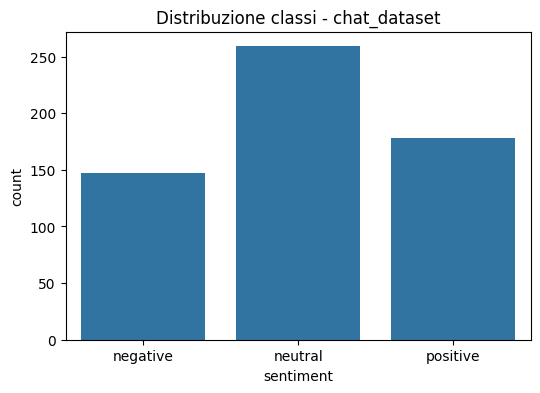

In [3]:
# Caricamento dati: training/val su chat_dataset, hold-out di confronto su mrev_clean
chat_path = '../data/processed/chat_dataset.csv'
mrev_path = '../data/processed/mrev_clean.csv'

labels_order = ['negative', 'neutral', 'positive']
sentiment_map = {label: idx for idx, label in enumerate(labels_order)}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}

# Dataset di training (chat)
df_chat = pd.read_csv(chat_path)
df_chat = df_chat.rename(columns={'message': 'review_text'})
df_chat = df_chat[['review_text', 'sentiment']].dropna()
df_chat['review_text'] = df_chat['review_text'].astype(str)
df_chat['sentiment'] = df_chat['sentiment'].str.lower()
df_chat['label'] = df_chat['sentiment'].map(sentiment_map)
df_chat = df_chat.dropna(subset=['label'])
df_chat = df_chat.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle esplicito

# Dataset di valutazione finale (mrev)
df_mrev = pd.read_csv(mrev_path)
df_mrev = df_mrev[['review_text', 'sentiment']].dropna()
df_mrev['review_text'] = df_mrev['review_text'].astype(str)
df_mrev['sentiment'] = df_mrev['sentiment'].str.lower()
df_mrev['label'] = df_mrev['sentiment'].map(sentiment_map)
df_mrev = df_mrev.dropna(subset=['label'])
df_mrev = df_mrev.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle esplicito

print(f"Training set (chat) size: {len(df_chat)}")
print(f"Hold-out (mrev) size: {len(df_mrev)}")
print(f"Classes: {sentiment_map}")

# Distribuzione classi sul dataset di training
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df_chat, order=labels_order)
plt.title('Distribuzione classi - chat_dataset')
plt.show()

In [4]:
# Suddivisione stratificata: 80% train, 20% val sul dataset di training
train_df, val_df = train_test_split(
    df_chat[['review_text', 'sentiment', 'label']],
    test_size=0.2,
    random_state=42,
    stratify=df_chat['label']
)

# Hold-out per confronto finale: tutto il dataset mrev (già shufflato)
test_df_mrev = df_mrev[['review_text', 'sentiment', 'label']].copy()

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test (mrev) size: {len(test_df_mrev)}")

Train size: 467 | Val size: 117 | Test (mrev) size: 110


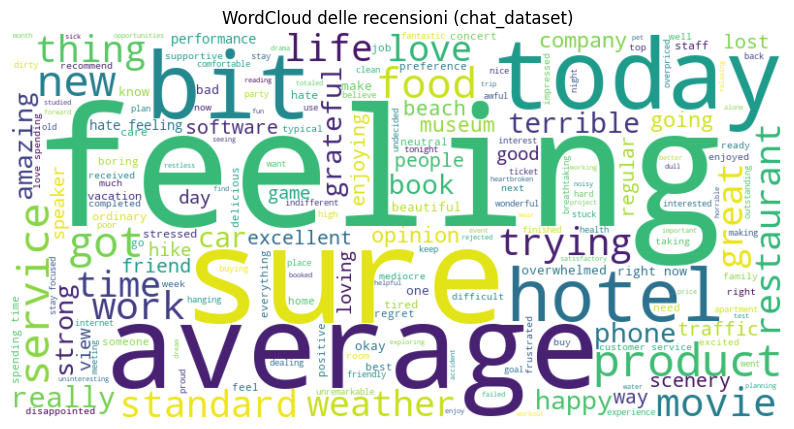

In [5]:
# Generazione WordCloud sul dataset di training (chat)
text_combined = " ".join(review for review in df_chat.review_text)

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud delle recensioni (chat_dataset)")
plt.show()

## 2. Modello 1: Custom LSTM (con GloVe Twitter)

Replichiamo l'architettura del notebook precedente.

In [6]:
# --- 2.1 Preprocessing specifico per LSTM ---
def clean_text_lstm(text):
    text = str(text).lower()
    # conserva emoji/emoticon rimuovendo solo url e caratteri di controllo
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[\r\n\t]+', ' ', text)
    text = re.sub(r'[^\w\s\U0001F300-\U0001FAFF]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applica il preprocessing e tokenizza le partizioni (train/val da chat, test da mrev)

def add_tokens(df_in):
    df_out = df_in.copy()
    df_out['clean_text'] = df_out['review_text'].apply(clean_text_lstm)
    df_out['tokens'] = df_out['clean_text'].apply(lambda x: x.split())
    return df_out

train_df_lstm = add_tokens(train_df)
val_df_lstm = add_tokens(val_df)
test_df_lstm = add_tokens(test_df_mrev)

# Vocabolario costruito solo sul training set
all_words = [word for tokens in train_df_lstm['tokens'] for word in tokens]
word_counts = Counter(all_words)
min_freq = 2
vocab_list = sorted([k for k, v in word_counts.items() if v >= min_freq])
vocab = {word: i + 1 for i, word in enumerate(vocab_list)}
vocab_size = len(vocab) + 1

# Conversione Testo -> Indici
def text_to_indices(tokens, vocab, max_len=50):
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

max_seq_len = 50
X_train_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in train_df_lstm['tokens']])
y_train_lstm = train_df_lstm['label'].values
X_val_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in val_df_lstm['tokens']])
y_val_lstm = val_df_lstm['label'].values
X_test_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in test_df_lstm['tokens']])
y_test_lstm = test_df_lstm['label'].values

# Dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader_lstm = DataLoader(ReviewDataset(X_train_lstm, y_train_lstm), batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(ReviewDataset(X_val_lstm, y_val_lstm), batch_size=32, shuffle=False)
test_loader_lstm = DataLoader(ReviewDataset(X_test_lstm, y_test_lstm), batch_size=32, shuffle=False)

# --- 2.2 Caricamento Embeddings GloVe ---
print("Caricamento GloVe Twitter... (potrebbe richiedere un po')")
try:
    glove_model = api.load("glove-twitter-100")
    embedding_dim = 100

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
except Exception as e:
    print(f"Errore caricamento GloVe: {e}. Uso embedding random.")
    embedding_dim = 100
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))

# --- 2.3 Definizione Modello ---
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(self.dropout(hidden))

# --- 2.4 Training Loop ---
model_lstm = SentimentLSTM(vocab_size, embedding_dim, 64, len(sentiment_map), embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print("Training LSTM...")
lstm_val_history = []
epochs = 5

for epoch in range(epochs):
    model_lstm.train()
    for X_b, y_b in train_loader_lstm:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model_lstm(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optimizer.step()

    # Validation
    model_lstm.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_b, y_b in val_loader_lstm:
            X_b = X_b.to(device)
            out = model_lstm(X_b)
            _, preds = torch.max(out, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_b.numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    lstm_val_history.append(val_acc)
    print(f"LSTM Epoch {epoch + 1}: Val Accuracy {val_acc:.4f}")

# Test finale sul hold-out mrev
model_lstm.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for X_b, y_b in test_loader_lstm:
        X_b = X_b.to(device)
        out = model_lstm(X_b)
        _, preds = torch.max(out, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y_b.numpy())

lstm_test_acc = accuracy_score(test_targets, test_preds)
lstm_test_f1 = f1_score(test_targets, test_preds, average='weighted')
lstm_cm = confusion_matrix(test_targets, test_preds)
print(f"LSTM Test Accuracy (mrev): {lstm_test_acc:.4f} | F1-weighted: {lstm_test_f1:.4f}")

# Salvataggio checkpoint LSTM in ../models (overwrite)
lstm_ckpt_dir = os.path.abspath(os.path.join('..', 'models'))
os.makedirs(lstm_ckpt_dir, exist_ok=True)
lstm_ckpt_path = os.path.join(lstm_ckpt_dir, 'lstm_sentiment.ckpt')
torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'vocab': vocab,
    'sentiment_map': sentiment_map,
}, lstm_ckpt_path)
print(f"Checkpoint LSTM salvato in {lstm_ckpt_path}")

Caricamento GloVe Twitter... (potrebbe richiedere un po')
Training LSTM...
LSTM Epoch 1: Val Accuracy 0.4444
LSTM Epoch 2: Val Accuracy 0.4444
LSTM Epoch 3: Val Accuracy 0.5128
LSTM Epoch 4: Val Accuracy 0.6239
LSTM Epoch 5: Val Accuracy 0.7350
LSTM Test Accuracy (mrev): 0.5727 | F1-weighted: 0.5798
Checkpoint LSTM salvato in c:\Users\Gabs\Desktop\faboulus-interpretr\models\lstm_sentiment.ckpt


## 3. Modello 2: XLM-RoBERTa (Fine-Tuning)

Usiamo la libreria `transformers` per fine-tunare `xlm-roberta-base`.

In [7]:
# --- 3.1 Preparazione Dati per Transformers ---
from peft import LoraConfig, TaskType, get_peft_model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

X_train_raw, y_train_raw = train_df['review_text'], train_df['label']
X_val_raw, y_val_raw = val_df['review_text'], val_df['label']
X_test_raw, y_test_raw = test_df_mrev['review_text'], test_df_mrev['label']

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=128)

# Creazione Dataset HuggingFace
train_dataset = HFDataset.from_dict({"text": X_train_raw.tolist(), "label": y_train_raw.tolist()})
val_dataset = HFDataset.from_dict({"text": X_val_raw.tolist(), "label": y_val_raw.tolist()})
test_dataset = HFDataset.from_dict({"text": X_test_raw.tolist(), "label": y_test_raw.tolist()})

train_tokenized = train_dataset.map(lambda x: tokenize_function(x['text']), batched=True)
val_tokenized = val_dataset.map(lambda x: tokenize_function(x['text']), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x['text']), batched=True)

# --- 3.2 Setup Trainer con LoRA ---
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(sentiment_map),
    id2label=reverse_sentiment_map,
    label2id=sentiment_map,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
).to(device)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    modules_to_save=["classifier"] # <--- Addestra e salva la testa di classificazione! 
)
model_xlm = get_peft_model(base_model, peft_config)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

xlm_ckpt_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora_checkpoints'))
xlm_final_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
os.makedirs(xlm_ckpt_dir, exist_ok=True)
os.makedirs(xlm_final_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=xlm_ckpt_dir,
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    learning_rate=2e-5,
    save_strategy="epoch",
    save_total_limit=1,
    overwrite_output_dir=True,
    use_cpu=not torch.cuda.is_available()
)
trainer = Trainer(
    model=model_xlm,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
)

# --- 3.3 Training ---
print("Training XLM-RoBERTa LoRA...")
trainer.train()

# Salva l'adapter LoRA (sovrascrive se esiste)
model_xlm.save_pretrained(xlm_final_dir)
tokenizer.save_pretrained(xlm_final_dir)

# Valutazione Finale su mrev (hold-out)
print("Valutazione su mrev (hold-out)...")
test_pred = trainer.predict(test_tokenized)
test_logits = test_pred.predictions
test_labels = test_pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)
xlm_test_acc = accuracy_score(test_labels, test_preds)
xlm_test_f1 = f1_score(test_labels, test_preds, average='weighted')
xlm_cm = confusion_matrix(test_labels, test_preds)
print(f"XLM-RoBERTa (LoRA) Test Accuracy (mrev): {xlm_test_acc:.4f} | F1-weighted: {xlm_test_f1:.4f}")

Map: 100%|██████████| 110/110 [00:00<00:00, 13174.19 examples/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training XLM-RoBERTa LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.069700,1.079143,0.444444,0.273504
2,1.069900,1.067019,0.444444,0.273504
3,1.050400,1.065477,0.444444,0.273504


Valutazione su mrev (hold-out)...


XLM-RoBERTa (LoRA) Test Accuracy (mrev): 0.2727 | F1-weighted: 0.1169


## 4. Confronto Risultati

### Confusion matrix sul test set (mrev hold-out)
Confrontiamo le confusion matrix complete per i due modelli sulle etichette reali del dataset `mrev_clean.csv` utilizzato come hold-out.

C:\Users\Gabs\AppData\Local\Temp\ipykernel_24696\3196505262.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=models, y=accuracies, palette='viridis')
C:\Users\Gabs\AppData\Local\Temp\ipykernel_24696\3196505262.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=models, y=f1_scores, palette='magma')


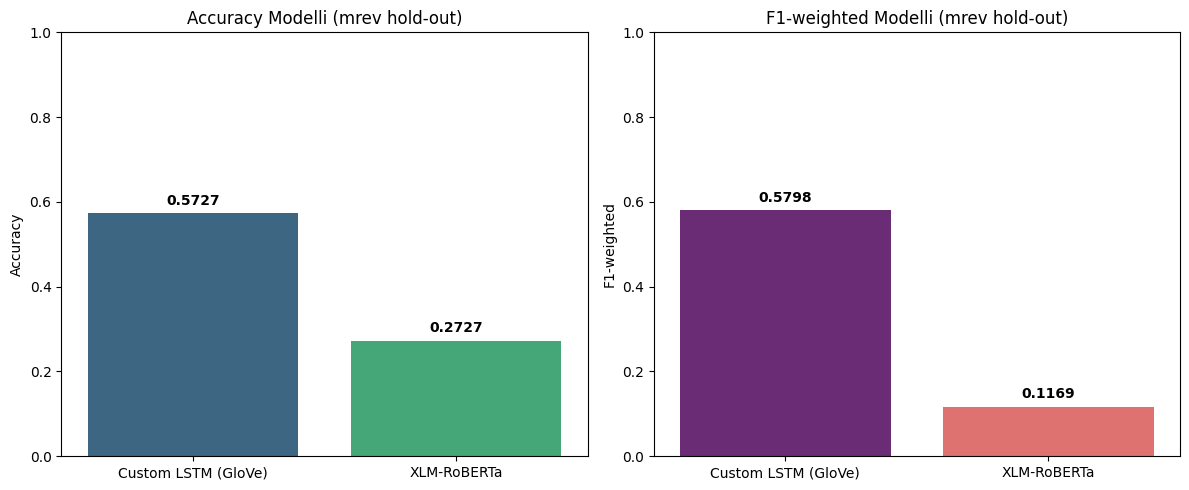

In [8]:
models = ['Custom LSTM (GloVe)', 'XLM-RoBERTa']
accuracies = [lstm_test_acc, xlm_test_acc]
f1_scores = [lstm_test_f1, xlm_test_f1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(ax=axes[0], x=models, y=accuracies, palette='viridis')
axes[0].set_ylim(0, 1)
axes[0].set_title('Accuracy Modelli (mrev hold-out)')
axes[0].set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

sns.barplot(ax=axes[1], x=models, y=f1_scores, palette='magma')
axes[1].set_ylim(0, 1)
axes[1].set_title('F1-weighted Modelli (mrev hold-out)')
axes[1].set_ylabel('F1-weighted')
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

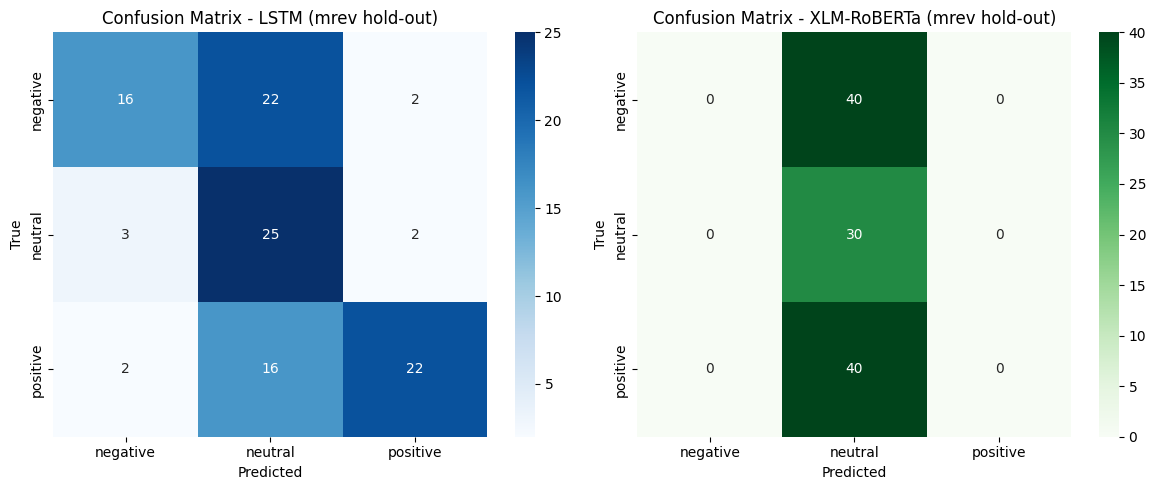

In [9]:
labels_order = list(reverse_sentiment_map.values())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM (mrev hold-out)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(xlm_cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title('Confusion Matrix - XLM-RoBERTa (mrev hold-out)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

## 5. Confronto rapido: LSTM vs BERT pre-addestrato su 30 esempi (mrev hold-out)

In [10]:
# Seleziona un campione casuale di 30 righe dal test set mrev (hold-out)
eval_df = test_df_lstm.sample(n=30, random_state=42).copy()
y_true = eval_df['sentiment'].str.lower().tolist()

# --- Predizioni LSTM sul sottoinsieme ---
X_eval_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in eval_df['tokens']])
lstm_preds = []
model_lstm.eval()
with torch.no_grad():
    for i in range(0, len(X_eval_lstm), 32):
        batch = torch.tensor(X_eval_lstm[i:i+32], dtype=torch.long).to(device)
        logits = model_lstm(batch)
        _, preds = torch.max(logits, 1)
        lstm_preds.extend([reverse_sentiment_map[p.item()].lower() for p in preds.cpu()])

# --- Predizioni BERT già addestrato (LoRA se presente) ---
lora_path = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
base_name = 'xlm-roberta-base'
id2label_fixed = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id_fixed = {v: k for k, v in id2label_fixed.items()}

bert_tokenizer = AutoTokenizer.from_pretrained(lora_path if os.path.exists(lora_path) else base_name)
bert_base = AutoModelForSequenceClassification.from_pretrained(
    base_name,
    num_labels=3,
    id2label=id2label_fixed,
    label2id=label2id_fixed,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
)
if os.path.exists(os.path.join(lora_path, 'adapter_config.json')):
    bert_model = PeftModel.from_pretrained(bert_base, lora_path)
else:
    bert_model = bert_base
bert_model.to(device)
bert_model.eval()

def predict_bert(texts, batch_size=8):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        with torch.no_grad():
            logits = bert_model(**inputs).logits
        class_ids = torch.argmax(logits, dim=-1).cpu().tolist()
        preds.extend([bert_model.config.id2label[c] for c in class_ids])
    return [p.lower() for p in preds]

bert_preds = predict_bert(eval_df['review_text'].tolist())

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Metriche di classificazione su 30 esempi casuali (mrev hold-out)
labels_order = ['negative', 'neutral', 'positive']

def evaluate_run(name, preds):
    acc = accuracy_score(y_true, preds)
    print(f"\n{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_true, preds, labels=labels_order, target_names=labels_order, digits=3))
    return acc, confusion_matrix(y_true, preds, labels=labels_order)

lstm_acc, cm_lstm = evaluate_run('LSTM', lstm_preds)
bert_acc, cm_bert = evaluate_run('BERT (xlm-roberta + LoRA)', bert_preds)


LSTM - Accuracy: 0.7667
              precision    recall  f1-score   support

    negative      0.833     0.455     0.588        11
     neutral      0.625     0.909     0.741        11
    positive      1.000     1.000     1.000         8

    accuracy                          0.767        30
   macro avg      0.819     0.788     0.776        30
weighted avg      0.801     0.767     0.754        30


BERT (xlm-roberta + LoRA) - Accuracy: 0.3667
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000        11
     neutral      0.367     1.000     0.537        11
    positive      0.000     0.000     0.000         8

    accuracy                          0.367        30
   macro avg      0.122     0.333     0.179        30
weighted avg      0.134     0.367     0.197        30



c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

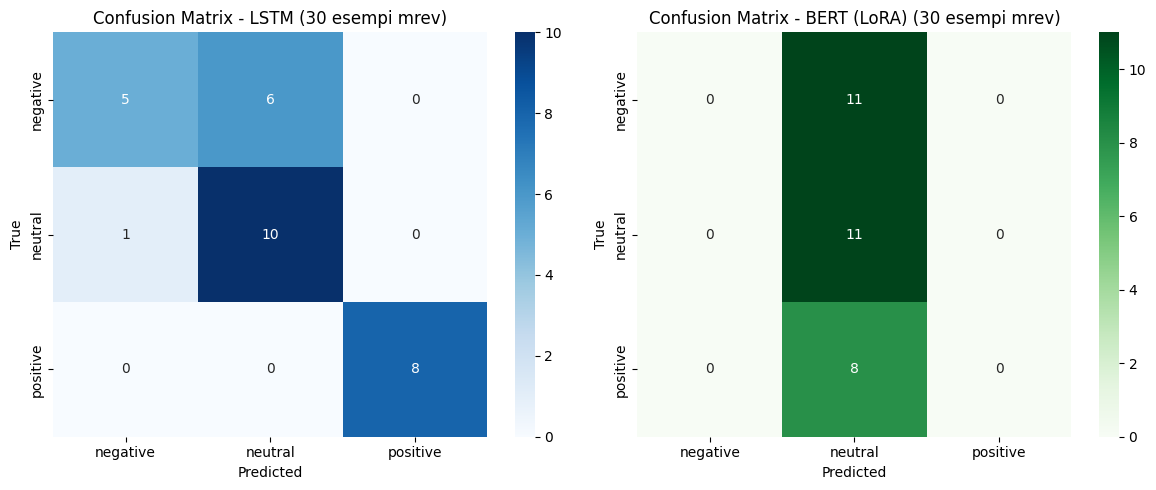

C:\Users\Gabs\AppData\Local\Temp\ipykernel_24696\1871651148.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')


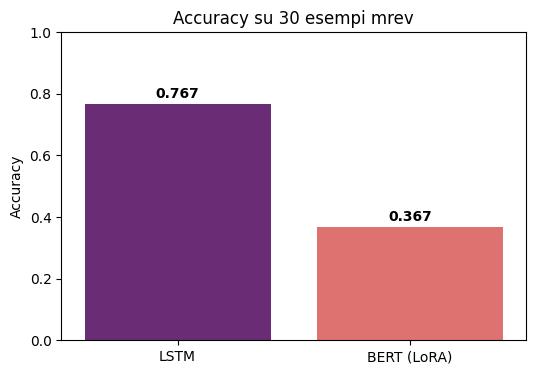

In [12]:
# Heatmap delle confusion matrix + confronto accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM (30 esempi mrev)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title('Confusion Matrix - BERT (LoRA) (30 esempi mrev)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

# Bar chart accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')
plt.ylim(0, 1)
for i, v in enumerate([lstm_acc, bert_acc]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.title('Accuracy su 30 esempi mrev')
plt.ylabel('Accuracy')
plt.show()